In [89]:
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import cdist
from datetime import date
from numpy import asarray
import seaborn as sns
import math

pd.options.mode.chained_assignment = None  # default='warn'

In [90]:
#Import Datasets
season_df = pd.read_csv('data/nfl_data_py/seasonal_data_2019_2023.csv')
draft_df = pd.read_csv('data/nfl_data_py/player_bio_2019_2023.csv')

In [95]:
def clean_bio_data(input_df):
    df = input_df.copy()

    #change gsis_id to player_id
    df.rename(columns={'gsis_id': 'player_id'}, inplace=True)

    #Convert birthdate from object to date 
    df['birthdate'] = pd.to_datetime(df['birthdate'])
    #drop the age column since this is a value calculated from date of scrape 
    df.drop(columns=['age'], inplace=True)

    #For undrafted players where draft round is null, set draft round to 8
    df['draft_round'] = df['draft_round'].fillna(8)
    #for players where draft round is 8, set draft pick to 1
    df['draft_pick'] = np.where(df['draft_round'] == 8, 1, df['draft_pick'])
    #for players where draft round is 8, set draft ovr as the max draft_ovr + 1
    df['draft_ovr'] = np.where(df['draft_round'] == 8, df['draft_ovr'].max() + 1, df['draft_ovr'])
    # #Convert draft round, pick and ovr to int
    # df['draft_round'] = df['draft_round'].astype(int)
    # df['draft_pick'] = df['draft_pick'].astype(int)
    # df['draft_ovr'] = df['draft_ovr'].astype(int)

    return df 

bio_df = clean_bio_data(draft_df)
bio_df.sample(5)

,player_id,name,position,team,birthdate,draft_year,draft_round,draft_pick,draft_ovr,height,weight
620,00-0034400,Jordan Wilkins,RB,FA,1994-07-18,2018.0,5.0,32.0,169.0,73.0,216.0
36,00-0038608,Kayshon Boutte,WR,NEP,2002-05-07,2023.0,6.0,10.0,187.0,72.0,197.0
1016,00-0027939,Cam Newton,QB,FA,1989-05-11,2011.0,1.0,1.0,1.0,77.0,245.0
1000,00-0029269,Travis Benjamin,WR,FA,1989-12-29,2012.0,4.0,5.0,100.0,70.0,175.0
773,00-0033720,Colin Thompson,TE,FA,1993-12-15,2017.0,8.0,1.0,263.0,76.0,255.0


In [96]:
def calculate_inseason_age(input_df, bio_df):
    season_df = input_df.copy()
    #for each season, set the start of the season as 9/1 of that year
    season_df['start_date'] = pd.to_datetime(season_df['season'].astype(str) + '-09-01')
    #Find the player's birthdate via the bio_df and merge on player_id
    season_df = season_df.merge(bio_df[['player_id', 'birthdate']], on='player_id', how='left')
    #calculate age at the start of the season and round down to nearest whole number
    season_df['age'] = (season_df['start_date'] - season_df['birthdate']).dt.days // 365
    
    return season_df.drop(columns=['start_date', 'birthdate'])

season_df = calculate_inseason_age(season_df, bio_df)
season_df.sample(5)

,name,position,age,player_id,season,completions,attempts,passing_yards,passing_tds,interceptions,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
1162,Zay Jones,WR,25,00-0033891,2020,1,1,29.0,0,0.0,...,0.043449,0.108976,0.047414,0.047619,0.038710,0.039773,0.047516,0.047455,0.381188,0.033112
2640,Jonathan Taylor,RB,24,00-0036223,2023,0,0,0.0,0,0.0,...,0.159633,0.099724,0.068365,0.142857,0.049020,0.055046,0.105611,0.083263,0.472222,0.201075
2054,Jerry Jeudy,WR,23,00-0036407,2022,0,0,0.0,0,0.0,...,0.222098,0.504357,0.268657,0.352941,0.278912,0.286585,0.310799,0.285514,1.924752,0.174155
1246,CeeDee Lamb,WR,22,00-0036358,2021,0,0,0.0,0,0.0,...,0.208906,0.508013,0.240192,0.157895,0.225532,0.216117,0.199043,0.223732,1.836667,0.136155
2169,Mecole Hardman,WR,24,00-0035140,2022,0,0,0.0,0,0.0,...,0.118694,0.247522,0.114012,0.190476,0.101449,0.113208,0.152244,0.129304,0.889222,0.102346


In [57]:
season_df = season_df.loc[season_df.fantasy_points >= 0]

## Calculating Similarity:
- Weight between 50% (abs. % difference of fantasy points) and 50% of euclidian distance of min-max scaled vector of tgts, recs, yards and TDs

In [97]:
def find_peers(season_df, target):
    #Find the position and age of the target player
    a_df = season_df.loc[season_df.name == target]
    a_df.reset_index(drop=True, inplace=True)
    position = a_df.position.min()
    #Find the age range of the player
    min_age = math.floor(a_df.age.min())
    # min_age = math.floor(min_age)
    max_age = math.ceil(a_df.age.max())
    # max_age = math.ceil(max_age)
    return_df = season_df.loc[(season_df.age >= min_age) & (season_df.age <= max_age) & (season_df.position == position)] 
    #return_df = season_df.loc[(season_df.Age <= max_age) & (season_df.Pos == position)] 
    return return_df

In [98]:
def abs_difference(peer_df, target):
    # peer_df = peer_df.drop_duplicates(subset = ['name', 'player_id', 'age'], keep='first')
    peer_pivot = peer_df.pivot(index = 'player_id', columns = 'age', values = 'fantasy_points').dropna(axis=0)
    #Find the target row's player_id
    target_id = peer_df.loc[peer_df.name == target].player_id.min()
    #create a reference row for the target player
    reference_row =peer_pivot.loc[peer_pivot.index == target_id].iloc[0]
    peer_fantasy = round(abs(peer_pivot.sub(reference_row) / reference_row),2)
    peer_fantasy.columns = 'age_' + peer_fantasy.columns.astype(int).astype(str)
    peer_fantasy['Avg'] = round(peer_fantasy.mean(axis = 1),2)
    compare = peer_fantasy.sort_values(by = 'Avg', ascending = True)
    fantasy_points = compare.loc[compare.index != target]
    fantasy_points = fantasy_points.sort_index()
    fantasy_points.sort_values(by = 'Avg', ascending = True, inplace=True)
    
    #Create a dict of player_id and name from the peer_df
    player_dict = peer_df[['player_id', 'name']].drop_duplicates().set_index('player_id').to_dict()['name']
    fantasy_points.index = fantasy_points.index.map(player_dict)
    
    return fantasy_points
    # return peer_fantasy

In [9]:
def euclid_rank(df, target_player, age):
    target = df.loc[df.Player == target_player]
    non = df.loc[df.Player != target_player]
    #Extract Feature Data
    ret_target = target.loc[:, target.columns.str.endswith("_Scaled")]
    ret_non = non.loc[:, target.columns.str.endswith("_Scaled")]
    #Calculate Euclidian Distance
    euclid = cdist(ret_non, ret_target,  'euclid')
    euclid = euclid.round(decimals=2)
    names = non.Player
    string = 'Age_{}'.format(str(age))
    col = [string]
    df = pd.DataFrame(data = euclid, index=names, columns = col)
    return df

In [99]:
peer_df = find_peers(season_df, 'Brandon Aiyuk')
abs_difference(peer_df, 'Brandon Aiyuk').head()

age,age_22,age_23,age_24,age_25,Avg
player_id,,,,,
Brandon Aiyuk,0.00,0.00,0.00,0.00,0.00
Christian Kirk,0.20,0.14,0.13,0.08,0.14
D.J. Moore,0.15,0.27,0.04,0.22,0.17
Marquise Brown,0.19,0.09,0.10,0.49,0.22
DK Metcalf,0.53,0.48,0.09,0.08,0.30


In [80]:
season_df.sample(5)

,name,position,age,player_id,season,completions,attempts,passing_yards,passing_tds,interceptions,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
2695,Khalil Shakir,WR,23,00-0037261,2023,0,0,0.0,0,0.0,...,0.153178,0.194124,0.150123,0.071429,0.138298,0.129630,0.110776,0.134384,1.135688,0.074344
573,Aaron Rodgers,QB,36,00-0023459,2020,372,526,4299.0,48,5.0,...,-0.000890,0.002078,-0.001396,0.000000,0.000000,0.000000,-0.000698,-0.001117,-0.011407,0.219299
1666,Ricky Seals-Jones,TE,26,00-0033611,2021,0,0,0.0,0,0.0,...,0.112012,0.254068,0.102110,0.166667,0.109375,0.114286,0.134388,0.115021,0.677500,0.077098
2880,Ty Montgomery,RB,30,00-0032200,2023,0,0,0.0,0,0.0,...,0.032727,0.110376,0.028510,0.000000,0.047619,0.042857,0.014255,0.022808,0.161290,0.020249
2068,Jonnu Smith,TE,27,00-0033858,2022,0,0,0.0,0,0.0,...,0.152672,0.179308,0.092036,0.000000,0.079646,0.073171,0.046018,0.073629,0.634715,0.058245


In [104]:
#Find the QBs from the season_df with the higest fantasy points
test = season_df.loc[season_df.position == 'WR'].sort_values(by = 'receiving_yards', ascending = False).head()
#set name as the index
test.set_index('name', inplace=True)
test[receiving_columns].drop(columns = receiving_columns_to_drop)

,receptions,targets,receiving_yards,receiving_tds,receiving_air_yards,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share
name,,,,,,,,,,
Cooper Kupp,145,191,1947.0,16,1641.0,89.0,111.882848,21.944290,5.495459,5.641115
Justin Jefferson,128,184,1809.0,8,1867.0,80.0,74.317037,17.137723,4.805573,6.710208
Tyreek Hill,119,171,1799.0,13,1847.0,83.0,92.695831,17.797357,5.282512,7.039244
CeeDee Lamb,135,181,1749.0,12,1722.0,80.0,102.466985,18.670705,4.983551,6.136823
Michael Thomas,149,185,1725.0,9,1497.0,91.0,98.997228,20.498168,5.285237,6.623741


In [81]:
season_df.columns

Index(['name', 'position', 'age', 'player_id', 'season', 'completions',
       'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks',
       'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr_x', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr',
       'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh',
       'rfd_sh', 'rtdfd_s

In [105]:
passing_columns = ['completions','attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks',
       'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota']
passing_columns_to_drop = ['passing_2pt_conversions', 'sack_yards','sack_fumbles', 'sack_fumbles_lost','passing_yards_after_catch']
#set passing_columns_base as the columns to keep
passing_columns_base = [x for x in passing_columns if x not in passing_columns_to_drop]

In [106]:
rushing_columns = ['carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']

rushing_columns_to_drop = ['rushing_fumbles_lost', 'rushing_2pt_conversions']
#set rushing_columns_base as the columns to keep
rushing_columns_base = [x for x in rushing_columns if x not in rushing_columns_to_drop]

In [107]:
receiving_columns = ['receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share']

receiving_columns_to_drop = ['receiving_fumbles', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'receiving_yards_after_catch', 'racr', 'airy_yards_share', 'target_share']
#set receiving_columns_base as the columns to keep
receiving_columns_base = [x for x in receiving_columns if x not in receiving_columns_to_drop]

In [10]:
def euclid_compare(peer_df, target):
    
    #Create list of Age ranges
    age_range = []
    
    #For Loop to Create Individual Dataframes of all unique ages
    for i in peer_df.Age.unique():
        a = str(i) 
        a = a[:-2]
        b = int(a)
        age_range.append(b)
        name = 'season_'+str(a)
        vars()[name] = peer_df.loc[peer_df.Age == i]
        #Run euclid rank
        euclid_name = 'euclid_'+str(a)
        vars()[euclid_name] = euclid_rank(df = vars()[name], target_player = target, age = a)
    
    age_range.sort()
    x = min(age_range)
    df_name = 'euclid_' +str(x)
    base_df = vars()[df_name]

    age_range_mod = age_range[1:]
    
    #Join all age dfs
    for i in age_range_mod:
        name = 'euclid_' +str(i)
        base_df = pd.merge(base_df, vars()[name], how = 'inner', on = 'Player')
    #Return Result
    else:
        base_df['Avg'] = round(base_df.mean(axis=1),2)
        return base_df.sort_values(by = 'Avg', ascending = True)

### Draft Similarity
- Find the relative draft similarity of the peers
- Calculate a Pick Score that's the average of both abs draft position and positional draft position
- Apply the Pick Score to the seasonal differences but weighted by seasons played
    - The more seasons played, the less pick score affects the similarity, and vice versa

In [11]:
def draft_position(output_df, draft_df, target):
    
    name_list = []
    
    for i in output_df.index:
        name_list.append(i)
    
    name_list.append(target)
    #Filter for output players
    peer_draft = draft_df.loc[draft_df.Player.isin(name_list)]
    
    return peer_draft

In [12]:
def draft_similarity(peer_draft, draft_df):
    #Identify the Target Player's draft position
    target_draft = peer_draft.loc[peer_draft.Player == target].iloc[0]
    
    #Calculate the Abs. Pick Difference
    peer_draft.loc[:,'Pick_Diff_Abs'] = abs(peer_draft['Pick'] - target_draft['Pick'])
    peer_draft.loc[:,'Pos_Pick_Diff_Abs'] = abs(peer_draft['Position_Pick'] - target_draft['Position_Pick'])
    peer_draft.loc[:,'Pick_Diff_Weight'] = round(1-peer_draft['Pick_Diff_Abs']/(32*7),2) #Total Picks
    
    #Calculate the average number of players drafted for each position
    agg = draft_df.groupby(by = ['Season', 'Pos'], as_index=False).count()
    agg = agg.groupby('Pos').mean()
    agg['Avg_Players_Drafted'] = round(agg['Player'],0)
    draft_avg = agg['Avg_Players_Drafted']
    draft_avg
    
    #Calculate the Positional Pick Difference
    position = peer_draft.Pos.mode()[0]
    Pos_Pick_Num = draft_avg.loc[draft_avg.index == position][0]
    peer_draft.loc[:,'Pos_Pick_Diff_Weight'] = round(1-peer_draft['Pos_Pick_Diff_Abs']/(Pos_Pick_Num),2) #Number of Players in the Position
    peer_draft.loc[:,'Pick_Score'] = round((peer_draft['Pos_Pick_Diff_Weight'] + peer_draft['Pick_Diff_Weight'])/2,2)
    peer_draft.sort_values(by = 'Pick_Score', ascending = False, inplace = True)
    peer_score = peer_draft[['Player', 'Pick_Score']]
    peer_score.set_index('Player', inplace=True)
    return peer_score.applymap(lambda x: max(0, x))

In [13]:
def draft_score_weighting(output_df, peer_score):
    #Weight the Pick Score based on the number of seasons played
    seasons_played = len(output_df.columns)-1

    #Divide Pick Score to Similarity Score - Weighted by the seasons played
    #The longer they've played, the impact the draft similarity has on the result
    peer_score_similarity = round(output_df.div(output_df.join(peer_score)['Pick_Score'], axis=0),2)
    output_df2 = round((output_df*seasons_played + peer_score_similarity)/(seasons_played+1),2)
    output_df2.sort_values(by = 'Avg', ascending = True, inplace = True)
    #output_df2.reset_index(inplace=True)
    return output_df2

In [14]:
def calculate_similarities(target, season_df, draft_df):
    #Find Peers
    peer_df = find_peers(season_df = season_df, target = target)
    
    #Calculate Abs. % Difference of each season
    fantasy_points = abs_difference(peer_df = peer_df, target = target)
    
    #Calculate Euclidean Distance
    euclid = euclid_compare(peer_df = peer_df, target = target)
    euclid = euclid.sort_index()
    euclid.sort_values(by = 'Avg', ascending = True, inplace=True)
    
    #Aggregate and Average the 2 metrics
    output_df = (fantasy_points + euclid) / 2
    output_df.sort_values(by = 'Avg', ascending=True, inplace=True)
    output_df = output_df.head(25)
    
    #Add the Draft Similarity Scores
    peer_draft = draft_position(output_df, draft_df, target)
    peer_score = draft_similarity(peer_draft, draft_df)
    final_output = draft_score_weighting(output_df, peer_score)
    final_output.dropna(subset=['Avg'], inplace=True)
    final_output = final_output.loc[final_output.Avg < 1]
    return final_output
    #return output_df

## Project Future Stats

In [15]:
def projection_stats(target, output, season_df):
    player_list = []

    #Identify the similar players
    for i in output.index:
        player_list.append(i)
        
    age = output.columns[-2]
    age = age.replace("Age_", "")
    age = float(age)
    #Look at the performances of the players in subsequent seasons
    projection_stats = season_df[season_df.Player.isin(player_list)]
    projection_stats = projection_stats.loc[projection_stats.Age > age]
    projection_stats['Age'] = projection_stats['Age'].astype(int).round()
    #Pivot the Data
    proj_points = projection_stats.pivot(index = 'Player', columns = 'Age', values = 'Fantasy_Points')
    proj_points = proj_points.reindex(output.index)
    proj_points.fillna(value = 0, inplace=True)
    proj_points['Total'] = proj_points.sum(axis = 1)
    proj_points = proj_points.loc[proj_points.Total > 0]
    proj_points.drop(columns = 'Total', inplace=True)
    return proj_points

In [16]:
def point_bucket(target, season_df):
    #Attach Rankings to Point Buckets
    position = season_df.loc[season_df.Player == target].Pos.min()
    latest = season_df.Season.max()
    latest_season_df = season_df.loc[(season_df.Season == latest) & (season_df.Pos == position)]

    point_max = int(latest_season_df.Fantasy_Points.max())
    ceiling = (math.ceil(point_max / 50) * 50)+1
    points_df = pd.DataFrame({'Fantasy_Points': range(0, ceiling, 50)})

    # Group the original dataframe by 50-point increments of points and calculate the mean rank
    latest_season_df['Points_bin'] = pd.cut(latest_season_df['Fantasy_Points'], range(0, ceiling, 50))
    avg_rank_df = latest_season_df.groupby('Points_bin')['Pos_Rank'].mean().reset_index()

    # Merge the two dataframes on the 'Points' column
    points_df['Avg_Rank'] = round(avg_rank_df['Pos_Rank'],1)
    if points_df.iloc[-1].isnull().values.any():
        # Drop the last row if it contains NaN values
        points_df = points_df.drop(points_df.index[-1])
        
    nan_index = points_df['Avg_Rank'].isna().idxmax()
    points_df.loc[nan_index, 'Avg_Rank'] = points_df.loc[nan_index-1:nan_index+1, 'Avg_Rank'].mean()
    
    return points_df

In [22]:
def visualize_projections(target, proj_points, output):
    #Remove columns (ages) where there is insufficient data
    zero_col = None
    for col in proj_points.columns:
        if (proj_points[col] == 0).sum() / len(proj_points) > 0.5:
            zero_col = col
            break

    # Remove all columns to the right of the zero column
    if zero_col is not None:
        proj_points = proj_points.loc[:, :zero_col]

    #Repeat the weights as row numbers
    output2 = output.copy()
    output2 = output2.apply(lambda x: (1 - x)*100)
    proj_points['Weight'] = output2['Avg']
        
    weighted_proj_points = proj_points.loc[np.repeat(proj_points.index.values, proj_points['Weight'])]
    weighted_proj_points.drop(columns = 'Weight', inplace = True)
    weighted_proj_points = weighted_proj_points[weighted_proj_points != 0]
    
    #Create Box Plot
    point_map = point_bucket(target = target, season_df = season_df)
    sns.set_style("whitegrid")
    #ax = 
    sns.violinplot(data=weighted_proj_points, palette="Set2")
    ax = plt.gca()
    ax.set_ylim(point_map.Fantasy_Points.min(), point_map.Fantasy_Points.max())
    ax.set_ylabel('Fantasy Points')
    
    #Create Twin Axis for Ranking
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(point_map['Avg_Rank'])
    ax2.set_ylabel('Positional Rank')


    # add median value labels
    medians = weighted_proj_points.median().values
    median_labels = [f'{val:.2f}' for val in medians]
    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 2.5, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # add title
    years = len(weighted_proj_points.columns)
    plt.title(f"Fantasy Points and Rank Projection for {target} over the next {years} seasons")

    # display the plot
    plt.show()
    proj_points.drop(columns = 'Weight', inplace = True)
    proj_points = proj_points.replace(0.0, np.nan)
    
    summary = proj_points.describe(percentiles=[0.25, 0.5, 0.75])
    return summary.loc[['max', '75%',  '50%','25%','min' ]], "Top 10 Similar Players:", output.head(10)

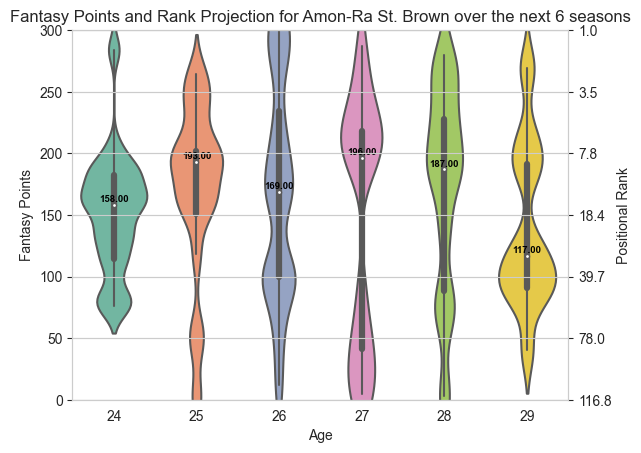

(Age     24     25     26     27      28     29
 max  284.0  264.0  311.0  287.0  280.00  269.0
 75%  178.0  207.5  234.0  218.0  227.50  189.0
 50%  158.0  189.5  169.0  196.0  187.00  117.0
 25%  121.0  157.0  100.0   41.0  101.25   91.5
 min   76.0    2.0   12.0    5.0    3.00   40.0,
 'Top 10 Similar Players:',
 Age              Age_22  Age_23   Avg
 Player                               
 Jarvis Landry      0.18    0.16  0.17
 Percy Harvin       0.13    0.26  0.20
 Andre Johnson      0.19    0.24  0.21
 CeeDee Lamb        0.16    0.25  0.21
 Tee Higgins        0.12    0.34  0.23
 Tyreek Hill        0.22    0.26  0.24
 Julio Jones        0.20    0.31  0.25
 Jordan Matthews    0.17    0.35  0.25
 Darrell Jackson    0.25    0.24  0.25
 Chris Godwin       0.20    0.32  0.26)

In [23]:
target = 'Amon-Ra St. Brown'
output = calculate_similarities(target = target, season_df = season_df, draft_df = draft_df)
proj_points = projection_stats(target = target, output = output, season_df = season_df)
visualize_projections(target = target, proj_points = proj_points, output = output)

- Add the name of the player in the box 
- Add existing age seasons (either as a line or as a bar, but enough to distinguish from the box and whiskerplots)